# Introduction
In Principal Component Analysis the goal is to reduce the dimensionality of the a dataset while retaining as much of its variability as possible. To understand variance we can think of how spread the data is around mean. For this specific reason capturing more variance in a dataset is considered desirable because it means that less information is being lost from the reduced dataset.

What PCA does is to essentially produce a set of orthogonal (but uncorrelated) principal components that explain the maximum amount of variance in the original dataset. Following this line of thought, the first principal component captures the largest amount of variance in the dataset, followed by the second principal component, and so on and so forth.

## How could we choose the right amount of PCAs?
Main objective when it comes to choosing the right number of principal components is to maintain a balance between capturing enough variance to represent the original dataset adequately while avoiding ovrefitting or retaining too much noise in the data.

There are several methods that we could follow to find what is the proper number of principal components and two of most used of them are:
- scree plot
- cross validation

### Scree plot
Below it will be demonstrated how to find the proper number of principal components from a given corpus of texts (i.e., a directory that contains text files).

Steps:
1) Import the necessary libraries (see below)
2) Read each file in the directory and append its content to an empty list.
3) Create a document-term tf-idf matrix (row = document | column = term). If you want to have normal frequencies then use the `CountVectorizer()`; if you want to have relative frequencies then use the `TfidfVectorizer()` (Remember that in this part you need to also choose the kind of features you want to have (e.g., if character 4-grams, then `ngram_range=(4,4), analyzer="char"`).
4) Obtain the eigenvalues for each principal component by performing PCA on the document-term matrix or the tf-idf matrix (eigenvalues=representation of the amount of variance explained by each principal component).
5) Plot the eigenvalues in a descending order (i.e., from the eigenvalue that captures the most variance to the eigenvalue that captures the less variance); this is the **scree plot**.
6) When examining the scree plot, look for the "elbow". The "elbow" is the point at which the eigenvalues start to level off. In other words, the number of PCs can be chosen based on the point where the "elbow" occurs.

By doing so, we can perform afterwards a Principal Component Analysis using only the number of PCs that capture the most variance in our data (i.e., the most important patterns).

## Relative Frequency PCA

In [2]:
from glob import glob
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from glob import glob
import pandas as pd

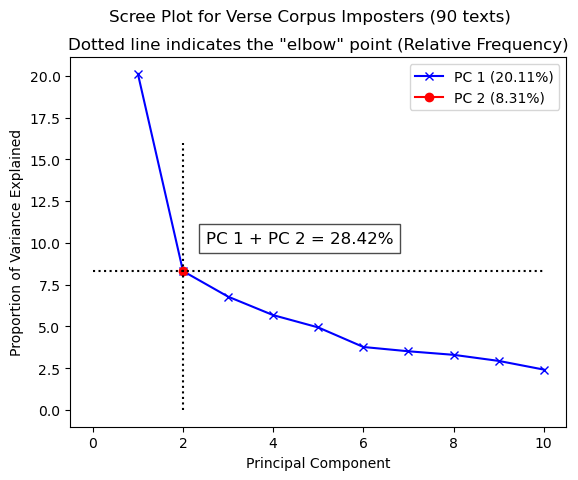

In [30]:
# read the contents of each txt file and append to a list
directory_path = glob('../../corpus_imposters/*.txt')
corpus = []
for file in directory_path:
    with open(file, 'r') as f:
        corpus.append(f.read())

# create a document-term matrix or a tf-idf matrix from the text corpus (TfidfVectorizer)
# focus on the relative freq. thus remove the idf (only word counts) and
# normalize using the l1 score instead of l2 (this will give back the relative freq)
# we do this because for our analysis we use the relative frequency for every method
# character 4grams in our case and 2000 MFCs
vectorizer = TfidfVectorizer(ngram_range=(
    4, 4), analyzer="char", lowercase=True, strip_accents="ascii", norm="l1", use_idf=False, max_features=2000)
doc_term_matrix = vectorizer.fit_transform(corpus)

# perform PCA on the matrix using PCA
# show only the first 10 components for readability purposes
pca = PCA(n_components=10)
pca.fit(doc_term_matrix.toarray())

# obtain the eigenvalues for each principal component
# and plot them in descending order using matplotlib
plt.plot(range(1, pca.n_components_+1), pca.explained_variance_ratio_ *
         100, '-b', marker='x', label="Principal Component")

# specify a different marker style for the second component (you can choose your desired marker)
plt.plot(2, pca.explained_variance_ratio_[
         1] * 100, '-r', marker='o', label="Principal Component 2")
plt.hlines(y=pca.explained_variance_ratio_[
           1] * 100, xmin=0, xmax=10, colors="k", linestyles="dotted")
plt.vlines(x=2, ymin=0, ymax=16, colors="k", linestyles="dotted")
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
labels = [f"PC {i} ({variance:.2f}%)"
          for i, variance in enumerate(pca.explained_variance_ratio_[:2] * 100, start=1)]
plt.legend(labels=labels)
plt.suptitle('Scree Plot for Verse Corpus Imposters (90 texts)')
plt.title('Dotted line indicates the "elbow" point (Relative Frequency)')
plt.text(2.5, 10, f"PC 1 + PC 2 = {round(pca.explained_variance_ratio_[:2].sum() * 100, 2)}%",
         fontsize=12, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
# create directory if not exist
os.makedirs("../PCA/scree_plot_res/", exist_ok=True)
plt.savefig("../PCA/scree_plot_res/scree_plot_pc.png",
            dpi=500)  # save the plot in the appointed file
plt.show()

## Projecting the Data onto the Principal Axes

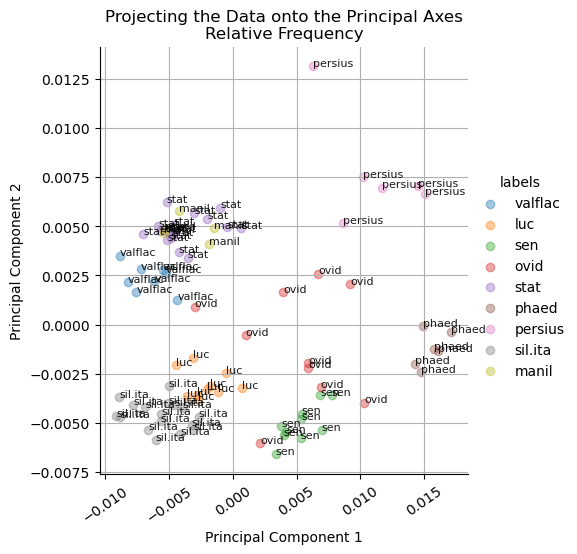

In [31]:
# transform the data using the fitted PCA model
data_transformed = pca.transform(doc_term_matrix.toarray())
# create a dataframe with the tranformed pca components
pca_df = pd.DataFrame(data=data_transformed, columns=[
                      f"PC_{i}" for i in range(1, pca.n_components_ + 1)])

# create the labels that have the following format: author_text_n.txt
filenames = [os.path.basename(file).split("_", maxsplit=1)[0]
             for file in glob("../../corpus_imposters/*.txt")]

pca_df["labels"] = filenames

# Use lmplot to create the scatter plot
sns.lmplot(x='PC_1', y='PC_2', data=pca_df, hue='labels',
           fit_reg=False, scatter_kws={'alpha': 0.4})

# Add labels to each point using plt.annotate()
for index, row in pca_df.iterrows():
    plt.annotate(row['labels'], (row['PC_1'], row['PC_2']),
                 fontsize=8, alpha=0.9)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xticks(rotation=35)
plt.grid()
plt.title('Projecting the Data onto the Principal Axes\nRelative Frequency')
plt.show()

## Train model using the Relative Frequency

Score for model with Tfidf score and 1 Principal Components: 0.278
Score for model with Tfidf score and 2 Principal Components: 0.611
Score for model with Tfidf score and 3 Principal Components: 0.556


/Users/paschalis/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score for model with Tfidf score and 4 Principal Components: 0.667
Score for model with Tfidf score and 5 Principal Components: 0.667


/Users/paschalis/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score for model with Tfidf score and 6 Principal Components: 0.722


/Users/paschalis/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score for model with Tfidf score and 7 Principal Components: 0.722
Score for model with Tfidf score and 8 Principal Components: 0.778


/Users/paschalis/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score for model with Tfidf score and 9 Principal Components: 0.889
Score for model with Tfidf score and 10 Principal Components: 0.889


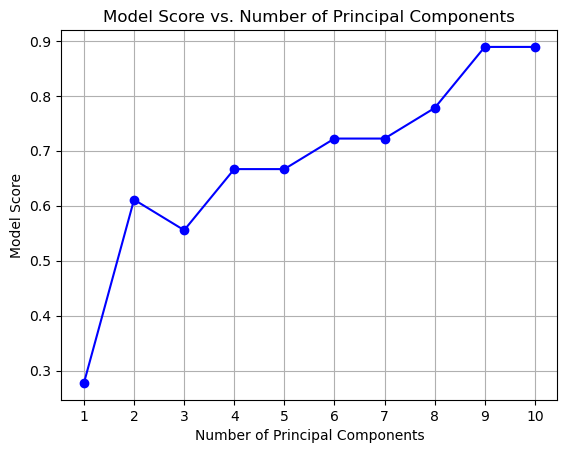

In [32]:
num_components = list(range(1, 11, 1))
scores = []
for n in num_components:
    pca_1 = PCA(n_components=n)

    # transform the data
    transformed_results = pca_1.fit_transform(doc_term_matrix.toarray())
    X = pd.DataFrame(transformed_results, columns=[
                     f"PC_{i}" for i in range(1, pca_1.n_components_ + 1)])
    labels = [os.path.basename(filename).split("_", maxsplit=1)[
        0] for filename in glob("../../corpus_imposters/*.txt")]
    labels = pd.Series(labels)
    y = labels.astype('category').cat.codes

    # split the data into train and test set (.8 train, .2 test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.2, random_state=42)

# create and initialise a Support Vector Classifier
    svc_1 = LinearSVC(dual=True, random_state=42,
                      multi_class="crammer_singer", max_iter=1000000000)
    svc_1.fit(X_train, y_train)
    score_tfidf = svc_1.score(X_test, y_test)
    scores.append(score_tfidf)
    print("Score for model with Tfidf score and {} Principal Components: {}".format(
        pca_1.n_components_, round(score_tfidf, 3)))

# Create the line plot
plt.plot(num_components, scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Model Score')
plt.title('Model Score vs. Number of Principal Components')
plt.xticks(num_components)
plt.grid(True)
plt.show()

# Conlusions
Looking at the scree plot above, we can observe that the elbow occurs at the 2th Principal Component (PC). The 1st PC captures 87.94% of the variance, whereas the 2nd PC captures only 4.16. The rest of them capture less than 1%, therefore not a lot of information is captured there. In total, by utilising these two PCs, the PCA is able to capture ≈92% of the data variance.

For the amount of variance that the first 10 PCs capture see the `print` output below:

In [33]:
variance_10_PC = [f"PC {i} ({variance:.2f}%)"
                  for i, variance in enumerate(pca.explained_variance_ratio_ * 100, start=1)]
for PC in variance_10_PC:
    print(PC)
print("-------------")
print(
    f"PC 1 + PC 2 capture {round(pca.explained_variance_ratio_[:2].sum() * 100, 2)}% of the variance in this corpus.")

PC 1 (20.11%)
PC 2 (8.31%)
PC 3 (6.78%)
PC 4 (5.67%)
PC 5 (4.94%)
PC 6 (3.77%)
PC 7 (3.51%)
PC 8 (3.30%)
PC 9 (2.93%)
PC 10 (2.41%)
-------------
PC 1 + PC 2 capture 28.42% of the variance in this corpus.


## Tfidf Vectorizer PCA

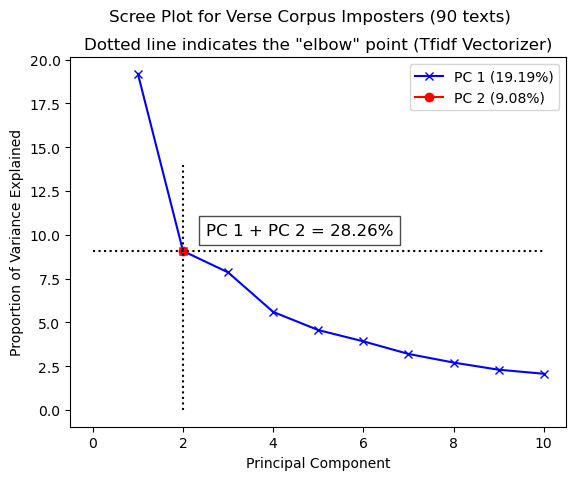

In [34]:
# read the contents of each txt file and append to a list
directory_path = glob('../../corpus_imposters/*.txt')
corpus = []
for file in directory_path:
    with open(file, 'r') as f:
        corpus.append(f.read())

# tf-idf vectorizer
vectorizer = TfidfVectorizer(ngram_range=(
    4, 4), analyzer="char", lowercase=True, strip_accents="ascii", max_features=2000)
doc_term_matrix = vectorizer.fit_transform(corpus)

# perform PCA on the matrix using PCA
# show only the first 10 components for readability purposes
pca = PCA(n_components=10)
pca.fit(doc_term_matrix.toarray())

# obtain the eigenvalues for each principal component
# and plot them in descending order using matplotlib
plt.plot(range(1, pca.n_components_+1), pca.explained_variance_ratio_ *
         100, '-b', marker='x', label="Principal Component")

# specify a different marker style for the second component (you can choose your desired marker)
plt.plot(2, pca.explained_variance_ratio_[
         1] * 100, '-r', marker='o', label="Principal Component 2")
plt.hlines(y=pca.explained_variance_ratio_[
           1] * 100, xmin=0, xmax=10, colors="k", linestyles="dotted")
plt.vlines(x=2, ymin=0, ymax=14, colors="k", linestyles="dotted")
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
labels = [f"PC {i} ({variance:.2f}%)"
          for i, variance in enumerate(pca.explained_variance_ratio_[:2] * 100, start=1)]
plt.legend(labels=labels)
plt.suptitle('Scree Plot for Verse Corpus Imposters (90 texts)')
plt.title('Dotted line indicates the "elbow" point (Tfidf Vectorizer)')
plt.text(2.5, 10, f"PC 1 + PC 2 = {round(pca.explained_variance_ratio_[:2].sum() * 100, 2)}%",
         fontsize=12, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
# create directory if not exist
os.makedirs("../PCA/scree_plot_res/", exist_ok=True)
plt.savefig("../PCA/scree_plot_res/scree_plot_pc.png",
            dpi=500)  # save the plot in the appointed file
plt.show()

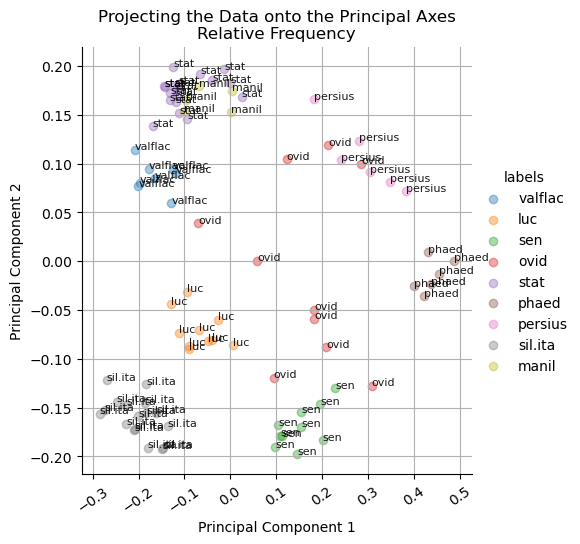

In [35]:
# transform the data using the fitted PCA model
data_transformed = pca.transform(doc_term_matrix.toarray())
# create a dataframe with the tranformed pca components
pca_df = pd.DataFrame(data=data_transformed, columns=[
                      f"PC_{i}" for i in range(1, pca.n_components_ + 1)])

# create the labels that have the following format: author_text_n.txt
filenames = [os.path.basename(file).split("_", maxsplit=1)[0]
             for file in glob("../../corpus_imposters/*.txt")]

pca_df["labels"] = filenames

# Use lmplot to create the scatter plot
sns.lmplot(x='PC_1', y='PC_2', data=pca_df, hue='labels',
           fit_reg=False, scatter_kws={'alpha': 0.4})

# Add labels to each point using plt.annotate()
for index, row in pca_df.iterrows():
    plt.annotate(row['labels'], (row['PC_1'], row['PC_2']),
                 fontsize=8, alpha=0.9)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xticks(rotation=35)
plt.grid()
plt.title('Projecting the Data onto the Principal Axes\nRelative Frequency')
plt.show()

## Train model using Tfidf score

Score for model with Tfidf score and 1 Principal Components: 0.389
Score for model with Tfidf score and 2 Principal Components: 0.5
Score for model with Tfidf score and 3 Principal Components: 0.667
Score for model with Tfidf score and 4 Principal Components: 0.611
Score for model with Tfidf score and 5 Principal Components: 0.667
Score for model with Tfidf score and 6 Principal Components: 0.889
Score for model with Tfidf score and 7 Principal Components: 0.889
Score for model with Tfidf score and 8 Principal Components: 0.889
Score for model with Tfidf score and 9 Principal Components: 0.889
Score for model with Tfidf score and 10 Principal Components: 0.889


/Users/paschalis/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/paschalis/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


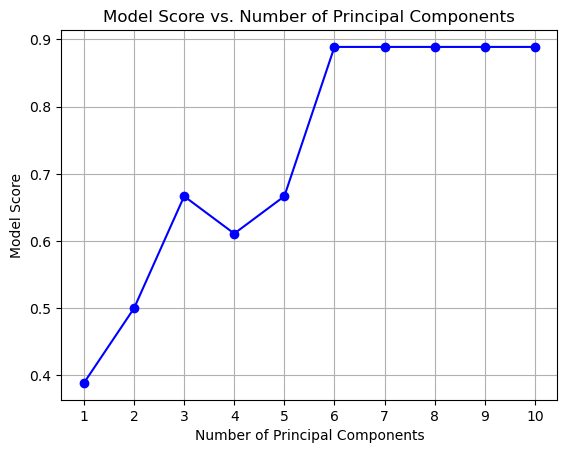

In [36]:
num_components = list(range(1, 11, 1))
scores = []
for n in num_components:
    pca_2 = PCA(n_components=n)

    # transform the data
    transformed_results = pca_2.fit_transform(doc_term_matrix.toarray())
    X = pd.DataFrame(transformed_results, columns=[
                     f"PC_{i}" for i in range(1, pca_2.n_components_ + 1)])
    labels = [os.path.basename(filename).split("_", maxsplit=1)[
        0] for filename in glob("../../corpus_imposters/*.txt")]
    labels = pd.Series(labels)
    y = labels.astype('category').cat.codes

    # split the data into train and test set (.8 train, .2 test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.2, random_state=42)

# create and initialise a Support Vector Classifier
    svc_2 = LinearSVC(dual=True, random_state=42,
                      multi_class="crammer_singer", max_iter=1000000000)
    svc_2.fit(X_train, y_train)
    score_tfidf = svc_2.score(X_test, y_test)
    scores.append(score_tfidf)
    print("Score for model with Tfidf score and {} Principal Components: {}".format(
        pca_2.n_components_, round(score_tfidf, 3)))

# Create the line plot
plt.plot(num_components, scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Model Score')
plt.title('Model Score vs. Number of Principal Components')
plt.xticks(num_components)
plt.grid(True)
plt.show()

In [37]:
variance_10_PC = [f"PC {i} ({variance:.2f}%)"
                  for i, variance in enumerate(pca.explained_variance_ratio_ * 100, start=1)]
for PC in variance_10_PC:
    print(PC)
print("-------------")
print(
    f"PC 1 + PC 2 capture {round(pca.explained_variance_ratio_[:2].sum() * 100, 2)}% of the variance in this corpus.")

PC 1 (19.19%)
PC 2 (9.08%)
PC 3 (7.86%)
PC 4 (5.60%)
PC 5 (4.56%)
PC 6 (3.92%)
PC 7 (3.20%)
PC 8 (2.70%)
PC 9 (2.30%)
PC 10 (2.07%)
-------------
PC 1 + PC 2 capture 28.26% of the variance in this corpus.


## Simple Frequency PCA

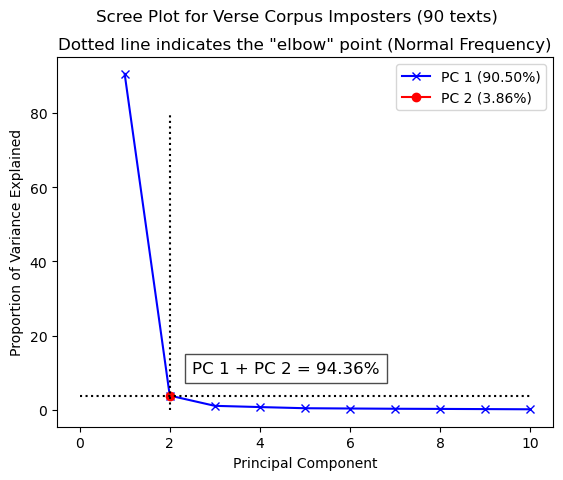

In [38]:
from glob import glob
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os


# read the contents of each txt file and append to a list
directory_path = glob('../../corpus_imposters/*.txt')
corpus = []
for file in directory_path:
    with open(file, 'r') as f:
        corpus.append(f.read())

# character 4grams in our case
vectorizer = CountVectorizer(ngram_range=(
    4, 4), analyzer="char", lowercase=True, strip_accents="ascii", max_features=2000)
doc_term_matrix = vectorizer.fit_transform(corpus)

# perform PCA on the matrix using PCA
# show only the first 10 components for readability purposes
pca = PCA(n_components=10)
pca.fit(doc_term_matrix.toarray())

# obtain the eigenvalues for each principal component
# and plot them in descending order using matplotlib
plt.plot(range(1, pca.n_components_+1), pca.explained_variance_ratio_ *
         100, '-b', marker='x', label="Principal Component")

# specify a different marker style for the second component (you can choose your desired marker)
plt.plot(2, pca.explained_variance_ratio_[
         1] * 100, '-r', marker='o', label="Principal Component 2")
plt.hlines(y=pca.explained_variance_ratio_[
           1] * 100, xmin=0, xmax=10, colors="k", linestyles="dotted")
plt.vlines(x=2, ymin=0, ymax=80, colors="k", linestyles="dotted")
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
labels = [f"PC {i} ({variance:.2f}%)"
          for i, variance in enumerate(pca.explained_variance_ratio_[:2] * 100, start=1)]
plt.legend(labels=labels)
plt.suptitle('Scree Plot for Verse Corpus Imposters (90 texts)')
plt.title('Dotted line indicates the "elbow" point (Normal Frequency)')
plt.text(2.5, 10, f"PC 1 + PC 2 = {round(pca.explained_variance_ratio_[:2].sum() * 100, 2)}%",
         fontsize=12, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
# create directory if not exist
# os.makedirs("../PCA/scree_plot_res/", exist_ok=True)
# plt.savefig("../PCA/scree_plot_res/scree_plot_pc.png",
#             dpi=500)  # save the plot in the appointed file
plt.show()

## Projecting the Data onto the Principal Axes

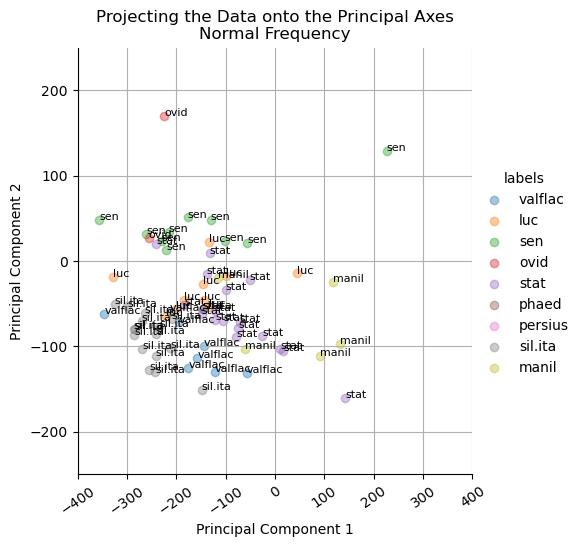

In [39]:
data_transformed = pca.transform(doc_term_matrix.toarray())
pca_df = pd.DataFrame(data_transformed, columns=[
                      f"PC_{i}" for i in range(1, pca.n_components + 1)])

labels = [os.path.basename(file).split("_", maxsplit=1)[0]
          for file in glob("../../corpus_imposters/*.txt")]

pca_df["labels"] = labels

sns.lmplot(x='PC_1', y='PC_2', data=pca_df, hue='labels',
           fit_reg=False, scatter_kws={'alpha': 0.4})

for index, row in pca_df.iterrows():
    plt.annotate(row['labels'], (row['PC_1'], row['PC_2']),
                 fontsize=8, alpha=1)


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(-400, 400)
plt.ylim(-250, 250)
plt.xticks(rotation=35)
plt.grid()
plt.title('Projecting the Data onto the Principal Axes\nNormal Frequency')
plt.show()

/Users/paschalis/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Score for model with Tfidf score and 1 Principal Components: 0.111
Score for model with Tfidf score and 2 Principal Components: 0.0
Score for model with Tfidf score and 3 Principal Components: 0.0
Score for model with Tfidf score and 4 Principal Components: 0.611
Score for model with Tfidf score and 5 Principal Components: 0.778
Score for model with Tfidf score and 6 Principal Components: 0.833
Score for model with Tfidf score and 7 Principal Components: 0.833
Score for model with Tfidf score and 8 Principal Components: 0.833
Score for model with Tfidf score and 9 Principal Components: 0.833
Score for model with Tfidf score and 10 Principal Components: 0.833


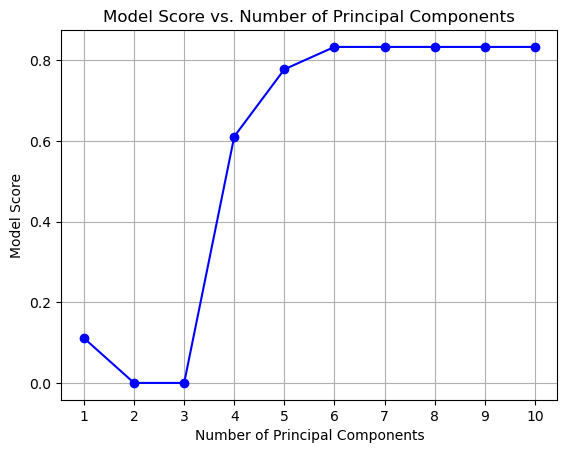

In [40]:
num_components = list(range(1, 11, 1))
scores = []
for n in num_components:
    pca_3 = PCA(n_components=n)

    # transform the data
    transformed_results = pca_3.fit_transform(doc_term_matrix.toarray())
    X = pd.DataFrame(transformed_results, columns=[
                     f"PC_{i}" for i in range(1, pca_3.n_components_ + 1)])
    labels = [os.path.basename(filename).split("_", maxsplit=1)[
        0] for filename in glob("../../corpus_imposters/*.txt")]
    labels = pd.Series(labels)
    y = labels.astype('category').cat.codes

    # split the data into train and test set (.8 train, .2 test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.2, random_state=42)

# create and initialise a Support Vector Classifier
    svc_3 = LinearSVC(dual=True, random_state=42,
                      multi_class="crammer_singer", max_iter=1000000000)
    svc_3.fit(X_train, y_train)
    score_tfidf = svc_3.score(X_test, y_test)
    scores.append(score_tfidf)
    print("Score for model with Tfidf score and {} Principal Components: {}".format(
        pca_3.n_components_, round(score_tfidf, 3)))

# Create the line plot
plt.plot(num_components, scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Model Score')
plt.title('Model Score vs. Number of Principal Components')
plt.xticks(num_components)
plt.grid(True)
plt.show()

In [41]:
variance_10_PC = [f"PC {i} ({variance:.2f}%)"
                  for i, variance in enumerate(pca.explained_variance_ratio_ * 100, start=1)]
for PC in variance_10_PC:
    print(PC)
print("-------------")
print(
    f"PC 1 + PC 2 capture {round(pca.explained_variance_ratio_[:2].sum() * 100, 2)}% of the variance in this corpus.")

PC 1 (90.50%)
PC 2 (3.86%)
PC 3 (1.10%)
PC 4 (0.77%)
PC 5 (0.46%)
PC 6 (0.38%)
PC 7 (0.31%)
PC 8 (0.27%)
PC 9 (0.22%)
PC 10 (0.17%)
-------------
PC 1 + PC 2 capture 94.36% of the variance in this corpus.


## Checking multiple models

/Users/paschalis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paschalis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paschalis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paschalis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paschalis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paschalis/opt/anaconda3

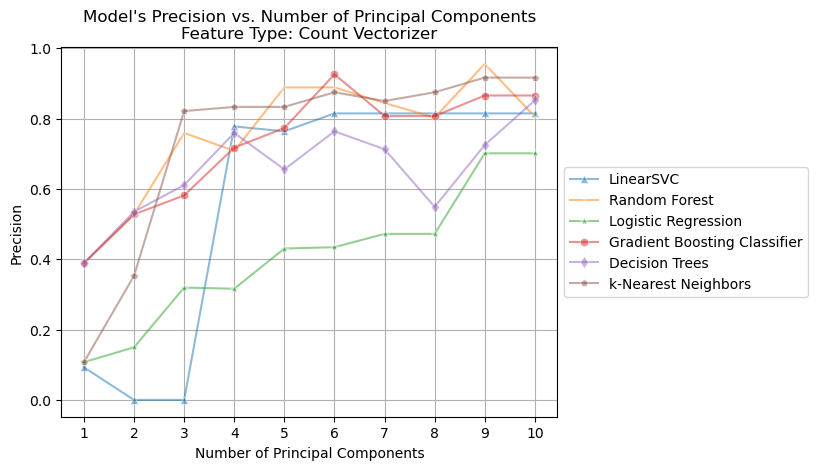

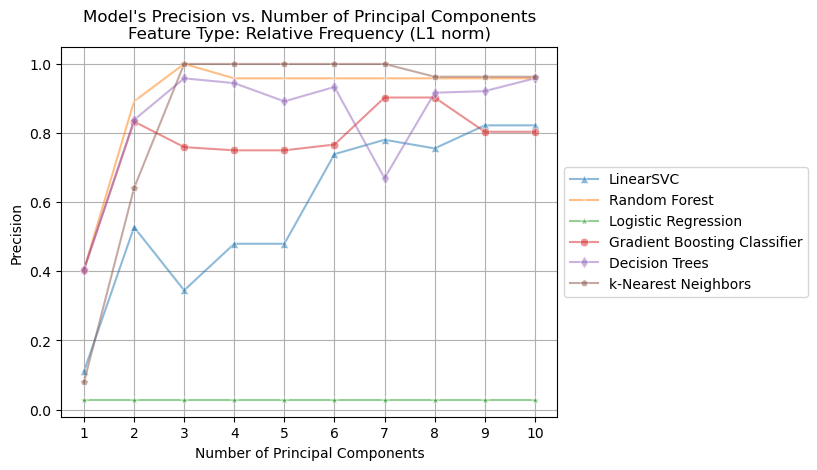

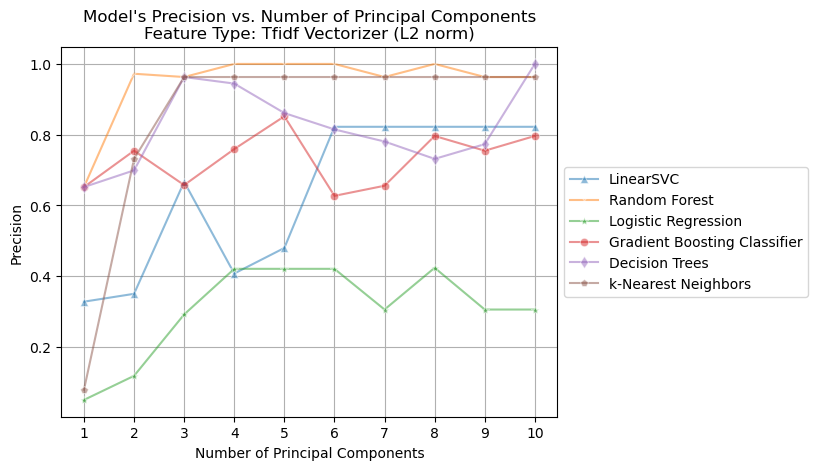

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the list of models to evaluate and corresponding model names
models = [LinearSVC(random_state=42, dual=True, multi_class="crammer_singer", max_iter=1000000000),
          RandomForestClassifier(random_state=42, bootstrap=True, n_jobs=-1),
          LogisticRegression(random_state=42, solver="saga",
                             multi_class="multinomial", n_jobs=-1),
          GradientBoostingClassifier(
              random_state=42, learning_rate=.0083, n_estimators=650),
          # MultinomialNB(), can handle only non-negative values, therefore will be excluded
          DecisionTreeClassifier(
              random_state=42, splitter="best", max_features="sqrt"),
          KNeighborsClassifier(algorithm="auto", metric="cosine", n_jobs=-1)]

model_names = ['LinearSVC', 'Random Forest',
               'Logistic Regression', 'Gradient Boosting Classifier', 'Decision Trees', 'k-Nearest Neighbors']

# Define the list of feature types (Count Vectorizer, Tfidf Vectorizer, and Relative Frequency)
vectorizers = [
    CountVectorizer(ngram_range=(4, 4), analyzer="char",
                    lowercase=True, strip_accents="ascii", max_features=2000),
    TfidfVectorizer(ngram_range=(4, 4), analyzer="char", lowercase=True,
                    strip_accents="ascii", norm="l1", use_idf=False, max_features=2000),
    TfidfVectorizer(ngram_range=(4, 4), analyzer="char", lowercase=True,
                    strip_accents="ascii", norm="l2", use_idf=True, max_features=2000)
]

# Lists to store the results
feature_names = ['Count Vectorizer',
                 'Relative Frequency (L1 norm)', 'Tfidf Vectorizer (L2 norm)']
evaluation_results = {}

# Loop through feature types
for vectorizer, feature_name in zip(vectorizers, feature_names):
    # Create the document-term matrix or TF-IDF matrix for the current feature type
    doc_term_matrix = vectorizer.fit_transform(corpus)

    # Initialize a dictionary to store evaluation results for the current feature type
    evaluation_results[feature_name] = {}

    # Loop through models
    for model, model_name in zip(models, model_names):
        scores = []
        for n in num_components:
            pca = PCA(n_components=n)
            transformed_results = pca.fit_transform(doc_term_matrix.toarray())
            X = pd.DataFrame(transformed_results, columns=[
                             f"PC_{i}" for i in range(1, pca.n_components_ + 1)])
            labels = [os.path.basename(filename).split("_", maxsplit=1)[
                0] for filename in glob("../../corpus_imposters/*.txt")]
            labels = pd.Series(labels)
            y = labels.astype('category').cat.codes

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=.2, random_state=42)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Evaluate the model using multiple metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(
                y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(
                y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted')

            scores.append({'n_components': n, 'accuracy': accuracy,
                          'precision': precision, 'recall': recall, 'f1': f1})

        evaluation_results[feature_name][model_name] = scores

# plot the evaluation results for each model and feature type
for feature_name in feature_names:
    plt.figure()
    # lineplot for Support Vector Machine (evaluation metric: precision)
    sns.lineplot(x=num_components, y=[result['precision'] for result in evaluation_results[feature_name]
                 ['LinearSVC']], marker='^', linestyle='-', label='LinearSVC', alpha=.5)
    # lineplot for Random Forest (evaluation metric: precision)
    sns.lineplot(x=num_components, y=[result['precision'] for result in evaluation_results[feature_name]
                 ['Random Forest']], marker='x', linestyle='-', label='Random Forest', alpha=.5)
    # lineplot for Logistic Regression (evaluation metric: precision)
    sns.lineplot(x=num_components, y=[result['precision'] for result in evaluation_results[feature_name]
                 ['Logistic Regression']], marker='*', linestyle='-', label='Logistic Regression', alpha=.5)
    # lineplot for Gradient Boosting Classifier (evaluation metric: precision)
    sns.lineplot(x=num_components, y=[result['precision'] for result in evaluation_results[feature_name]
                 ['Gradient Boosting Classifier']], marker='o', linestyle='-', label='Gradient Boosting Classifier', alpha=.5)
    # lineplot for Decision Trees (evaluation metric: precision)
    sns.lineplot(x=num_components, y=[result['precision'] for result in evaluation_results[feature_name]
                 ['Decision Trees']], marker='d', linestyle='-', label='Decision Trees', alpha=.5)
    # lineplot for k-Nearest Neighbors (evaluation metric: precision)
    sns.lineplot(x=num_components, y=[result['precision'] for result in evaluation_results[feature_name]
                 ['k-Nearest Neighbors']], marker='p', linestyle='-', label='k-Nearest Neighbors', alpha=.5)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Precision')
    plt.title(
        f"Model's Precision vs. Number of Principal Components\nFeature Type: {feature_name}")
    plt.xticks(num_components)
    plt.legend(loc='center left', bbox_to_anchor=(1, .5))
    plt.grid(True)
    plt.savefig(
        f"../PCA/scree_plot_res/{feature_name.replace(' ', '_').replace('(', '').replace(')', '').lower()}.png", dpi=500, bbox_inches='tight')
    plt.show()

# Accessing the loading of a PCA
See which features are the most important in each PC (total number of 10).

## Relative Frequency

In [29]:
import pandas as pd
# load the corpus
# read the contents of each txt file and append to a list
directory_path = glob('../../corpus_imposters/*.txt')
corpus = []
for file in directory_path:
    with open(file, 'r') as f:
        corpus.append(f.read().replace("\n", " "))

# create a document-term matrix or a tf-idf matrix from the text corpus (TfidfVectorizer)
# focus on the relative freq. thus remove the idf (only word counts) and
# normalize using the l1 score instead of l2 (l1 will give back the relative freq)
# we do this because for our analysis we use the relative frequency for every method
# character 4grams in our case and 2000 MFCs
vectorizer = TfidfVectorizer(ngram_range=(
    4, 4), analyzer="char", lowercase=True, strip_accents="ascii", norm="l1", use_idf=False, max_features=2000)

tfidf_matrix = vectorizer.fit_transform(corpus)

n_components = 10
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(tfidf_matrix.toarray())

# get the loadings
loadings = pca.components_


# Assuming you have the original character n-grams from the TfidfVectorizer
# You can obtain them using vectorizer.get_feature_names()
character_ngrams = vectorizer.get_feature_names_out()

# Create a DataFrame to store the results
loadings_df = pd.DataFrame(loadings, columns=character_ngrams)

# Get the top N influential features for each principal component
num_top_features = 10  # Choose the number of top features you want to see

top_features = {}
for component in range(n_components):
    sorted_features = loadings_df.iloc[component].abs(
    ).sort_values(ascending=False)
    top_features[component] = sorted_features.index[:num_top_features].tolist()

# Print the top N influential features for each principal component
for component, features in top_features.items():
    print(f"Principal Component {component + 1}: {features}")

Principal Component 1: ['que ', ' qui', ' est', 'sque', 'est ', 'quid', 'mque', ' quo', 'us a', 'uid ']
Principal Component 2: ['que ', 'tum ', 'bat ', ' uir', 'uit ', ', qu', 'aque', 'ebat', ' con', 'ens ']
Principal Component 3: [' et ', 's et', ' qui', ' iam', ' qua', ' per', 'quid', ' con', 'iam ', ', qu']
Principal Component 4: ['cum ', 'enti', 'ere ', ' cum', 'tus ', ' in ', 'tum ', 'dere', 'iam ', ' reg']
Principal Component 5: [' et ', 's et', ', et', 'que ', ' non', 'is, ', 'non ', ' con', ' qui', 'mque']
Principal Component 6: ['nec ', ' nec', 'bat ', ' vic', ' reg', 'is. ', 'ine ', ' cor', 'sque', ' mih']
Principal Component 7: [' in ', ' est', ' ill', 'sign', 'est ', 't et', ' sig', ' cae', 'ere ', ', et']
Principal Component 8: ['ere ', ' non', 'mihi', ' mih', 'non ', ' quo', 'ihi ', 'vis ', ' ing', 'us, ']
Principal Component 9: [' reg', ' ill', ', et', 'it, ', ' qua', 'que ', ' non', 'es, ', 'ris ', 'unt ']
Principal Component 10: [' et ', 'iam ', ' nec', ' iam', 'nec ',

## Normal Frequency

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# create a document-term matrix or a tf-idf matrix from the text corpus (TfidfVectorizer)
# focus on the relative freq. thus remove the idf (only word counts) and
# normalize using the l1 score instead of l2 (l1 will give back the relative freq)
# we do this because for our analysis we use the relative frequency for every method
# character 4grams in our case and 2000 MFCs
count_vectorizer = CountVectorizer(ngram_range=(
    4, 4), analyzer="char", lowercase=True, strip_accents="ascii", max_features=2000)

count_vec_matrix = count_vectorizer.fit_transform(corpus)

n_components = 10
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(tfidf_matrix.toarray())

# get the loadings
loadings = pca.components_


# Assuming you have the original character n-grams from the TfidfVectorizer
# You can obtain them using vectorizer.get_feature_names()
character_ngrams = vectorizer.get_feature_names_out()

# Create a DataFrame to store the results
loadings_df = pd.DataFrame(loadings, columns=character_ngrams)

# Get the top N influential features for each principal component
num_top_features = 10  # Choose the number of top features you want to see

top_features = {}
for component in range(n_components):
    sorted_features = loadings_df.iloc[component].abs(
    ).sort_values(ascending=False)
    top_features[component] = sorted_features.index[:num_top_features].tolist()

# Print the top N influential features for each principal component
for component, features in top_features.items():
    print(f"Principal Component {component + 1}: {features}")

Principal Component 1: ['que ', ' qui', ' est', 'sque', 'est ', 'quid', 'mque', ' quo', 'us a', 'uid ']
Principal Component 2: ['que ', 'tum ', 'bat ', ' uir', 'uit ', ', qu', 'aque', 'ebat', ' con', 'ens ']
Principal Component 3: [' et ', 's et', ' qui', ' iam', ' qua', ' per', 'quid', ' con', 'iam ', ', qu']
Principal Component 4: ['cum ', 'enti', 'ere ', ' cum', 'tus ', ' in ', 'tum ', 'dere', 'iam ', ' reg']
Principal Component 5: [' et ', 's et', ', et', 'que ', ' non', 'is, ', 'non ', ' con', ' qui', 'mque']
Principal Component 6: ['nec ', ' nec', 'bat ', ' vic', ' reg', 'is. ', 'ine ', ' cor', 'sque', ' mih']
Principal Component 7: [' in ', ' est', ' ill', 'sign', 'est ', 't et', ' sig', ' cae', 'ere ', ', et']
Principal Component 8: ['ere ', ' non', 'mihi', ' mih', 'non ', ' quo', 'ihi ', 'vis ', ' ing', 'us, ']
Principal Component 9: [' reg', ' ill', ', et', 'it, ', ' qua', 'que ', ' non', 'es, ', 'ris ', 'unt ']
Principal Component 10: [' et ', 'iam ', ' nec', ' iam', 'nec ',

## TF-IDF score

In [32]:
# create a document-term matrix or a tf-idf matrix from the text corpus (TfidfVectorizer)
# focus on the relative freq. thus remove the idf (only word counts) and
# normalize using the l1 score instead of l2 (l1 will give back the relative freq)
# we do this because for our analysis we use the relative frequency for every method
# character 4grams in our case and 2000 MFCs
vectorizer = TfidfVectorizer(ngram_range=(
    4, 4), analyzer="char", lowercase=True, strip_accents="ascii", norm="l2", use_idf=True, max_features=2000)

tfidf_matrix = vectorizer.fit_transform(corpus)

n_components = 10
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(tfidf_matrix.toarray())

# get the loadings
loadings = pca.components_


# Assuming you have the original character n-grams from the TfidfVectorizer
# You can obtain them using vectorizer.get_feature_names()
character_ngrams = vectorizer.get_feature_names_out()

# Create a DataFrame to store the results
loadings_df = pd.DataFrame(loadings, columns=character_ngrams)

# Get the top N influential features for each principal component
num_top_features = 10  # Choose the number of top features you want to see

top_features = {}
for component in range(n_components):
    sorted_features = loadings_df.iloc[component].abs(
    ).sort_values(ascending=False)
    top_features[component] = sorted_features.index[:num_top_features].tolist()

# Print the top N influential features for each principal component
for component, features in top_features.items():
    print(f"Principal Component {component + 1}: {features}")

Principal Component 1: ['que ', ' qui', ' est', 'sque', 'est ', ' quo', 'quid', ' uir', 'mque', 'quod']
Principal Component 2: ['que ', ' uir', 'tum ', 'bat ', ' vir', 'e vi', 'aque', 'ebat', 'a vi', ', qu']
Principal Component 3: [' et ', 's et', ' iam', ', qu', ', et', ' qui', 'iam ', ' qua', ' in ', ' per']
Principal Component 4: [' et ', ' reg', 'tus ', ' par', ' sce', ' fer', ' per', 's et', 'ens ', ' dic']
Principal Component 5: ['ere ', ', et', ' non', 'non ', ' con', ' uir', 'is, ', 'que ', 'unt ', 'mque']
Principal Component 6: [' uir', ' nec', ' ill', 'nec ', 'bat ', 'mund', 'erat', ' cae', 'rum ', 'amor']
Principal Component 7: [' est', ' ill', ' par', 'cael', 'per ', ' uir', ' per', ', et', 'it, ', ' sig']
Principal Component 8: [' mih', 'mihi', 'ihi ', ' iam', 'iam ', ' est', ' in ', 'est ', 'tis ', 'tum ']
Principal Component 9: [' non', ' et ', 'non ', ' qui', 's et', ', qu', ' iam', ' quo', 'que ', ' vul']
Principal Component 10: [' et ', 'que ', 'ere ', 'mihi', ' mih',